In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ofa-ai-mastery-computer-vision/Sample_submission.csv
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/623.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/208.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/473.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/333.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/537.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/45.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/369.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/56.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/654.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/89.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/20.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/275.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/212.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/239.jpg
/kaggle/input/ofa-ai-mastery-computer-vision/test/test/

# **Import Pakages**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
path = '/kaggle/input/ofa-ai-mastery-computer-vision'

# **Visualisai Data**

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,horse,600
1,dog,900
2,cat,700
3,deer,600


Mengumpulkan informasi tentang jumlah sampel dalam setiap kelas dalam sebuah dataset.

<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

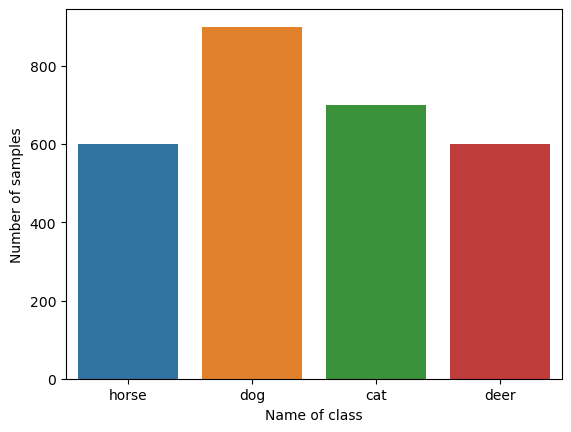

In [ ]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

Visualisasi grafik batang dari data yang sudah diolah

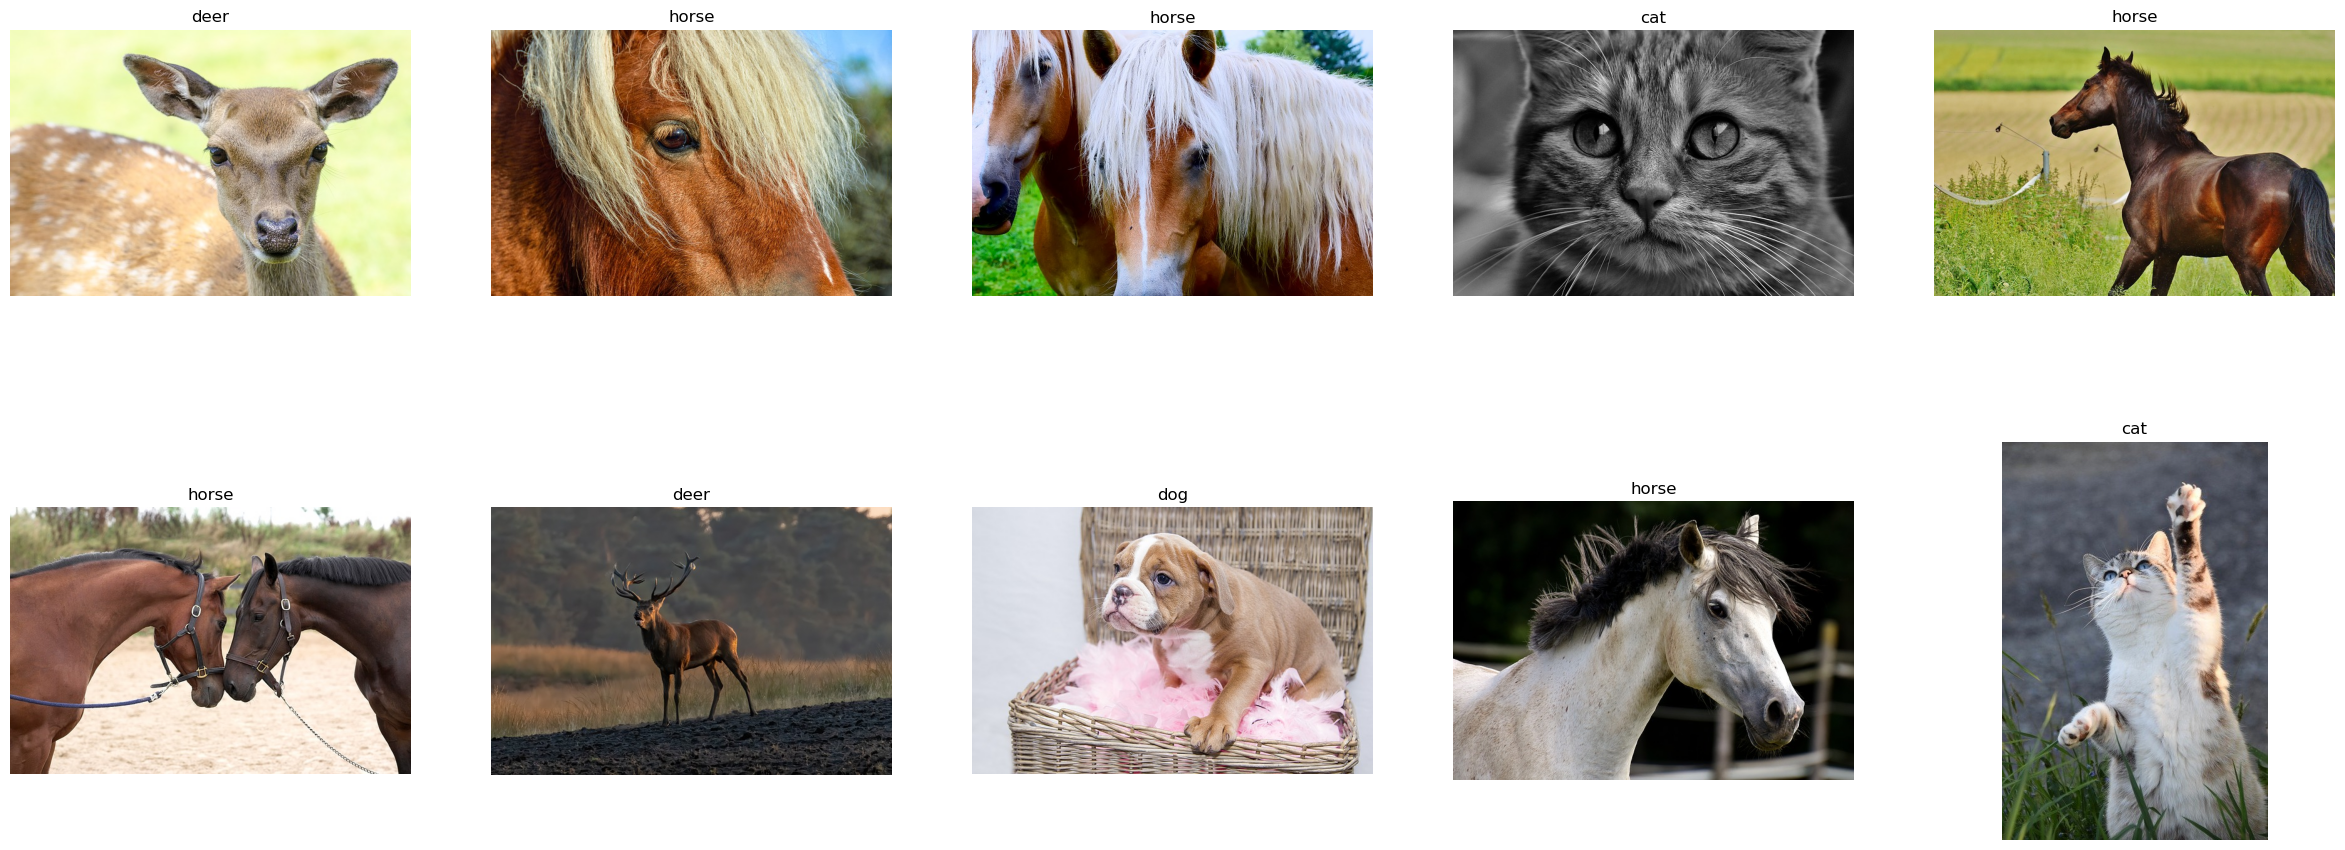

In [ ]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

Menampilkan sampel-sampel gambar dari dataset 

# **Preparing Data**

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)


Kode ini menggunakan modul ImageDataGenerator dari Keras untuk melakukan augmentasi data pada setiap batch gambar yang digunakan saat pelatihan model.

- Pertama, kode membuat sebuah objek ImageDataGenerator dengan memanggil kelas "tf.keras.preprocessing.image.ImageDataGenerator()".
Pada parameter "rescale", nilai 1./255 digunakan untuk melakukan normalisasi piksel gambar ke dalam rentang 0-1.
- Pada parameter "rotation_range", nilai 20 digunakan untuk mengatur range derajat rotasi gambar yang mungkin terjadi saat augmentasi data.
- Pada parameter "width_shift_range" dan "height_shift_range", nilai 0.2 digunakan untuk mengatur range pergeseran horizontal dan vertikal gambar yang mungkin terjadi saat augmentasi data.
- Pada parameter "horizontal_flip", nilai "True" digunakan untuk mengaktifkan flip horizontal pada gambar.
- Terakhir, pada parameter "validation_split", nilai 0.2 digunakan untuk membagi data menjadi data pelatihan dan data validasi secara otomatis oleh objek ImageDataGenerator.

In [ ]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=32)

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


Kode ini menggunakan objek ImageDataGenerator yang telah dibuat sebelumnya untuk membuat objek "train_ds" dan "val_ds" yang merupakan generator data untuk pelatihan dan validasi model.

- Pertama, kode memanggil method "flow_from_directory()" dari objek ImageDataGenerator untuk membuat generator data pelatihan.
- Pada parameter "directory", kode memberikan path ke folder "train" yang berisi data pelatihan.
- Pada parameter "subset", nilai "training" digunakan untuk menandakan bahwa generator yang dibuat akan digunakan untuk data pelatihan, sedangkan nilai "validation" digunakan pada objek "val_ds" untuk menandakan bahwa generator yang dibuat akan digunakan untuk data validasi.
- Pada parameter "target_size", nilai (224, 224) digunakan untuk menentukan ukuran gambar yang akan dihasilkan oleh generator.
Pada parameter "batch_size", nilai 32 digunakan untuk menentukan ukuran batch data yang akan dihasilkan oleh generator.

# **Building The Model**

In [ ]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

17225924/17225924 [==============================] - 0s 0us/step


Kode ini digunakan untuk membuat sebuah arsitektur model neural network untuk klasifikasi gambar dengan menggunakan pre-trained model MobileNet sebagai base model.

- Pertama, kode membuat sebuah objek MobileNet dengan memanggil kelas "tf.keras.applications.mobilenet.MobileNet()".
- Pada parameter "input_shape", nilai (224, 224, 3) digunakan untuk menentukan dimensi input gambar yang akan digunakan pada model.
- Pada parameter "include_top", nilai "False" digunakan untuk menandakan bahwa layer terakhir pada MobileNet tidak akan diikutsertakan pada model yang akan dibuat.
- Pada parameter "weights", nilai "imagenet" digunakan untuk menginisialisasi bobot-bobot pada model MobileNet dengan bobot-bobot dari pre-trained model MobileNet yang telah dilatih pada dataset ImageNet.

Setelah objek MobileNet dibuat, kode membuat sebuah model neural network dengan menggunakan MobileNet sebagai base model.

- Pertama, kode membuat sebuah objek "Sequential" untuk menampung layer-layer pada model.
- Selanjutnya, objek MobileNet ditambahkan pada model dengan menggunakan method "add()".
- Kemudian, sebuah layer "GlobalAveragePooling2D" ditambahkan pada model untuk mengubah feature map yang dihasilkan oleh MobileNet menjadi sebuah vektor.
- Selanjutnya, sebuah layer "Flatten" ditambahkan pada model untuk mengubah vektor tersebut menjadi sebuah array satu dimensi.
- Selanjutnya, tiga layer Dense ditambahkan pada model dengan masing-masing terdiri dari 1024, 512, dan 4 unit neuron.
Pada layer terakhir, fungsi aktivasi "softmax" digunakan untuk melakukan klasifikasi gambar pada empat kelas yang ada.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

Kode ini digunakan untuk melakukan kompilasi model yang telah dibuat sebelumnya.

- Pertama, kode menggunakan optimizer "SGD" dengan learning rate sebesar 0.0005 dan momentum sebesar 0.9. Optimizer ini digunakan untuk mengoptimalkan parameter-parameter pada model selama proses training.
- Selanjutnya, loss function yang digunakan adalah "categorical_crossentropy". Loss function ini digunakan untuk mengukur kesalahan prediksi dari model pada task klasifikasi multiclass.
- Pada parameter "metrics", nilai "accuracy" digunakan untuk memonitor performa model selama proses training.

Setelah model dikompilasi, kode menggunakan method "summary()" pada objek model untuk menampilkan informasi mengenai arsitektur model yang telah dibuat, termasuk jumlah parameter yang perlu di-training. Informasi ini sangat berguna untuk membantu kita memahami bagaimana model bekerja, dan berapa banyak waktu dan sumber daya yang dibutuhkan untuk melatih model tersebut.

# **Training & Evaluation**

In [ ]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 29)

Epoch 1/29
70/70 [==============================] - 74s 846ms/step - loss: 0.8612 - accuracy: 0.6888 - val_loss: 0.4468 - val_accuracy: 0.8768
Epoch 2/29
70/70 [==============================] - 50s 713ms/step - loss: 0.3339 - accuracy: 0.9085 - val_loss: 0.2871 - val_accuracy: 0.9071
Epoch 3/29
70/70 [==============================] - 50s 715ms/step - loss: 0.2227 - accuracy: 0.9281 - val_loss: 0.2162 - val_accuracy: 0.9393
Epoch 4/29
70/70 [==============================] - 49s 697ms/step - loss: 0.1707 - accuracy: 0.9509 - val_loss: 0.2061 - val_accuracy: 0.9375
Epoch 5/29
70/70 [==============================] - 49s 700ms/step - loss: 0.1392 - accuracy: 0.9589 - val_loss: 0.1885 - val_accuracy: 0.9446
Epoch 6/29
70/70 [==============================] - 49s 698ms/step - loss: 0.1264 - accuracy: 0.9616 - val_loss: 0.1689 - val_accuracy: 0.9429
Epoch 7/29
70/70 [==============================] - 49s 701ms/step - loss: 0.0978 - accuracy: 0.9719 - val_loss: 0.1454 - val_accuracy: 0.9411

Kode ini digunakan untuk melakukan pelatihan (training) model yang telah dibuat sebelumnya menggunakan data yang telah di-generate sebelumnya dengan ImageDataGenerator.

- Parameter pertama adalah "train_ds" yang berisi data latih yang telah di-generate sebelumnya.
- Parameter kedua adalah "validation_data" yang berisi data validasi yang telah di-generate sebelumnya.
- Parameter ketiga adalah "epochs", yang menentukan jumlah epoch atau iterasi yang digunakan untuk melatih model.

Hasil dari proses pelatihan tersebut disimpan pada variabel "history", yang berisi informasi mengenai nilai loss dan accuracy dari model pada setiap epoch yang digunakan untuk melatih model. Informasi tersebut dapat digunakan untuk melakukan visualisasi performa model selama proses training dan mengevaluasi performa model setelah proses training selesai.

18/18 [==============================] - 10s 532ms/step - loss: 0.1042 - accuracy: 0.9589


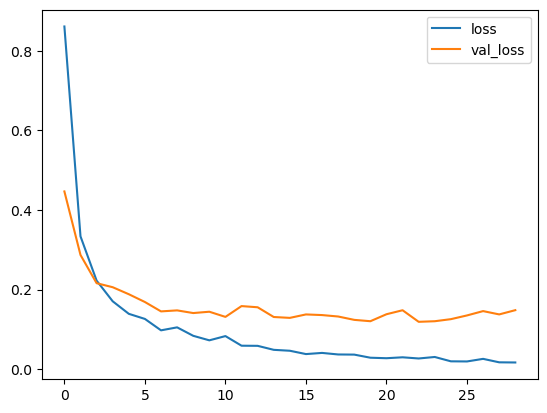

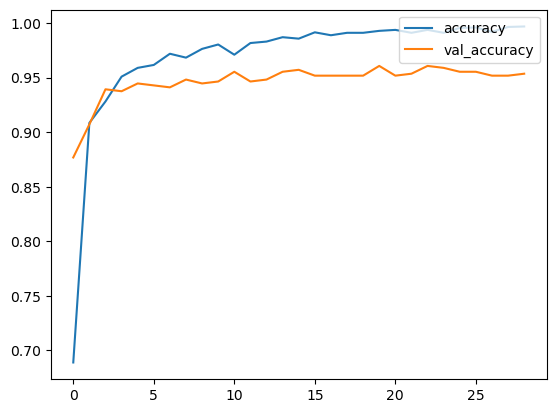

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

Kode ini digunakan untuk mengevaluasi performa model pada data validasi menggunakan method "evaluate" dan menampilkan grafik loss dan accuracy model selama proses training.

Dari grafik tersebut, kita dapat melihat bagaimana performa model pada setiap epoch selama proses training dan mengevaluasi sudah konvergen. 

#  **Preparing for submission**

In [ ]:
sub_csv ='/kaggle/input/ofa-ai-km-4-computer-vision/submission.csv'
path_test = '/kaggle/input/ofa-ai-mastery-computer-vision/test/test'

Kode tersebut menginisialisasi dua variabel yaitu "sub_csv" dan "path_test" dengan nilai path file csv yang berisi submission format dan path folder yang berisi data gambar yang akan digunakan untuk membuat prediksi pada tahap selanjutnya.

In [ ]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,0


Kode tersebut membaca file csv submission format menggunakan library pandas dan mengambil kolom "ID" dari dataframe tersebut untuk disimpan ke dalam variabel "image_id". Dataframe kemudian di-print untuk memastikan data sudah terbaca dengan benar.

Pada kasus ini, hasil output kode akan menampilkan 10 baris pertama dari dataframe "df_sub" yang berisi kolom "ID" dan "Label" yang akan diisi dengan hasil prediksi model.

In [ ]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 29ms/step


Kode tersebut melakukan prediksi pada setiap gambar dalam direktori "path_test" dan menyimpan hasil prediksi ke dalam list "labels". Proses prediksi dilakukan pada setiap gambar dengan memuatnya menggunakan fungsi "load_img" dari library keras dan mengubahnya menjadi array numpy dengan normalisasi nilai pixelnya dengan pembagian 255.0. Gambar kemudian direshape menjadi (1, 224, 224, 3) yang merepresentasikan batch_size, lebar, tinggi, dan channel (RGB).

Setelah itu, dilakukan prediksi menggunakan model dan disimpan dalam list "labels" dengan mengambil indeks dari nilai prediksi tertinggi.

In [ ]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


Kode tersebut mengganti kolom kosong pada dataframe "df_sub" dengan hasil prediksi yang disimpan dalam list "labels". Kemudian data output ditampilkan 10 baris pertama.

In [ ]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)